# Modeling *E. coli* growth

In [1]:
import cobra
from matplotlib import pyplot
import escher
import numpy
from qbio_resources.phase_plane import calculate_phenotype_phase_plane
from qbio_resources.plotting_functions import visualize_flux

%matplotlib inline

/Users/coltonlloyd/Envs/qbio18/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/coltonlloyd/Envs/qbio18/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## A) Modeling growth on varying electron acceptors

The use of the electron transport chain (ETC) and oxidative respiration enables highly efficient ATP generation in *E. coli*. An essential component of the ETC, however, is the presence of an electronegative electron acceptor as the strong attraction between electrons and the acceptor essentially powers the process.

Oxygen is the most ubiquitous bacterial electron acceptor and therefore bacterial are often only considered as growing either aerobically or anaerobically. However, E. coli has evolved to various other chemicals as electron acceptors in the absence of oxygen. Some of these include:

- Nitrate (NO3)
- Nitrite (NO2)
- Dimethylsulfoxide (DMSO)
- Trimethylamine N-oxide (TMAO)

This section will assess the efficacy of some of these additional electron acceptors to produce ATP

### 1) Load the model and save it as a variable called `model`
 - Since the cellular ATP requirements should be considered in totality, the lower bound of the non-growth dependent ATP maintenance reaction (ATPM) should not be set to 0

In [2]:
model = cobra.io.load_json_model('../qbio_resources/iML1515.json')

### 2) Begin by optimizing the model using `pfba()` in default aerobic conditions 
- Save the solution in a variable called `solution`

In [3]:
solution = cobra.flux_analysis.pfba(model)

### 3) Observe the flux balance of periplasm hydrogen (h_p) using the `metabolite.summary()` function
 - This function provides all the reaction creating and consuming h_p
 - The gradient of hydrogen across the inner membrane (i.e., a build of hydrogen in periplasmic space) ultimately powers ATP synthesis via the ATP synthase (ATPS4rpp) reaction
 - The sum of fluxes producing h_p will be proportional to the amount of ATP the cell can synthesize

In [4]:
model.metabolites.h_p.summary()

PRODUCING REACTIONS -- H+ (h_p)
-------------------------------
%      FLUX  RXN ID      REACTION
---  ------  ----------  --------------------------------------------------
61%  177     CYTBO3_4pp  4.0 h_c + 0.5 o2_c + q8h2_c --> h2o_c + 4.0 h_p...
39%  114     NADH16pp    4.0 h_c + nadh_c + q8_c --> 3.0 h_p + nad_c + q...

CONSUMING REACTIONS -- H+ (h_p)
-------------------------------
%      FLUX  RXN ID      REACTION
---  ------  ----------  --------------------------------------------------
97%  282     ATPS4rpp    adp_c + 4.0 h_p + pi_c <=> atp_c + h2o_c + 3.0 h_c
3%     8.06  Htex        h_e <=> h_p


### 4) Observe the flux balance of NAD+ (nad_c) using the `metabolite.summary()` function
 - Reduced NADH donates the electrons that enter ETC and provide the energy to translocate h+ accross the inner membrane
 - NAD must be available within the cell in order for glycolysis. If the cell does not have a way to oxidize NADH to NAD via the ETC, then it likely must look for other methods of doing so.

In [5]:
model.metabolites.nad_c.summary()

PRODUCING REACTIONS -- Nicotinamide adenine dinucleotide (nad_c)
----------------------------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
95%  38      NADH16pp  4.0 h_c + nadh_c + q8_c --> 3.0 h_p + nad_c + q...
5%    1.92   FADRx     fad_c + h_c + nadh_c --> fadh2_c + nad_c

CONSUMING REACTIONS -- Nicotinamide adenine dinucleotide (nad_c)
----------------------------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
43%  17.1    GAPD      g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c
24%   9.69   PDH       coa_c + nad_c + pyr_c --> accoa_c + co2_c + nadh_c
17%   6.88   MDH       mal__L_c + nad_c <=> h_c + nadh_c + oaa_c
15%   5.97   AKGDH     akg_c + coa_c + nad_c --> co2_c + nadh_c + succ...
4%    1.51   PGCD      3pg_c + nad_c --> 3php_c + h_c + nadh_c
1%    0.395  IPMD      3c2hmp_c + nad_c --

### 5) Calculate the efficiency of the electron acceptor to produce ATP
 - This will be the ratio of ATP synthesis flux powered by H+ and the flux of electron acceptor reduction

**Hint:** it's a reasonable assumption that the electron acceptor will be reduced at the rate it is taken up

In [6]:
print('Efficiency =', model.reactions.ATPS4rpp.flux / abs(model.reactions.EX_o2_e.flux))

Efficiency = 3.1824167329954554


### 6) Use `model.summary()` to receive an output of the metabolite uptake and secretion fluxes 
- Note the secretion products (out fluxes). 
- The solution can also be observed over a flux map using `visualize_flux(reaction_fluxes)` like in Exercise 1

In [7]:
model.summary()

IN FLUXES            OUT FLUXES    OBJECTIVES
-------------------  ------------  ----------------------
o2_e      22.1       h2o_e  47.2   BIOMASS_Ec_i...  0.877
glc__D_e  10         co2_e  24
nh4_e      9.47      h_e     8.06
pi_e       0.846
so4_e      0.221
k_e        0.171
fe2_e      0.0141
mg2_e      0.00761
ca2_e      0.00456
cl_e       0.00456
cu2_e      0.000622
mn2_e      0.000606
zn2_e      0.000299
ni2_e      0.000283


In [8]:
visualize_flux(solution.fluxes)

### 7) Repeate 1-6 with $\mathrm{NO_3}$ (no3) as the electron acceptor instead of oxygen

 - Allow unlimited (-1000 $\frac{mmol}{gDW \cdot hr}$) uptake of no3_e
 - Note the stoichiometry of the reactions capable of translocating H+ into the periplasm
   - NO3 is less electronegative and thus can power less translocation of H+ against the electrochemical gradient
   
 - **Don't forget to the set oxygen uptake to 0 and reset the uptake of the no3 to 0 after this analysis!**
 

In [9]:
model = cobra.io.load_json_model('../qbio_resources/iML1515.json')
model.reactions.EX_o2_e.lower_bound = 0
model.reactions.EX_no3_e.lower_bound = -1000
solution = cobra.flux_analysis.pfba(model)

In [10]:
model.metabolites.h_p.summary()

PRODUCING REACTIONS -- H+ (h_p)
-------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
56%  134     NADH16pp  4.0 h_c + nadh_c + q8_c --> 3.0 h_p + nad_c + q...
44%  106     NO3R1pp   2.0 h_c + no3_c + q8h2_c --> h2o_c + 2.0 h_p + ...

CONSUMING REACTIONS -- H+ (h_p)
-------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
97%  231     ATPS4rpp  adp_c + 4.0 h_p + pi_c <=> atp_c + h2o_c + 3.0 h_c
3%     7.15  Htex      h_e <=> h_p


In [11]:
model.metabolites.nad_c.summary()

PRODUCING REACTIONS -- Nicotinamide adenine dinucleotide (nad_c)
----------------------------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
96%   44.6   NADH16pp  4.0 h_c + nadh_c + q8_c --> 3.0 h_p + nad_c + q...
4%     1.7   FADRx     fad_c + h_c + nadh_c --> fadh2_c + nad_c

CONSUMING REACTIONS -- Nicotinamide adenine dinucleotide (nad_c)
----------------------------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
39%   17.9   GAPD      g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c
24%   11.3   PDH       coa_c + nad_c + pyr_c --> accoa_c + co2_c + nadh_c
19%    8.82  MDH       mal__L_c + nad_c <=> h_c + nadh_c + oaa_c
17%    8.01  AKGDH     akg_c + coa_c + nad_c --> co2_c + nadh_c + succ...
3%     1.34  PGCD      3pg_c + nad_c --> 3php_c + h_c + nadh_c


In [12]:
print('Efficiency =', model.reactions.ATPS4rpp.flux / abs(model.reactions.EX_no3_e.flux))

Efficiency = 1.0936020424579018


In [13]:
model.summary()

IN FLUXES            OUT FLUXES    OBJECTIVES
-------------------  ------------  ----------------------
no3_e     52.8       no2_e  52.8   BIOMASS_Ec_i...  0.778
glc__D_e  10         h2o_e  48.6
nh4_e      8.4       co2_e  28.1
pi_e       0.75      h_e     7.15
so4_e      0.196
k_e        0.152
mg2_e      0.00675
fe2_e      0.00642
fe3_e      0.00607
ca2_e      0.00405
cl_e       0.00405
cu2_e      0.000551
mn2_e      0.000537
zn2_e      0.000265
ni2_e      0.000251


In [14]:
visualize_flux(solution.fluxes)

### 8) Repeate 1-6 with Dimethylsulfoxide (dmso_e) as the electron acceptor instead of oxygen
 - Allow unlimited (-1000 $\frac{mmol}{gDW \cdot hr}$) uptake of dmso_e
 - Note the number of reactions capable of translocating H+ into the periplasm and the stoichiometry of those reactions
   - DMSO is even less electronegative then no3 and thus can power less translocation of H+ against the electrochemical gradient
 - Also note the byproduct secretion. Performing the `metabolite.summary()` command for atp_c will give clues to why this is happening
  - **Don't forget to the set oxygen uptake to 0 and reset the uptake of the dmso to 0 after this analysis!**

In [15]:
model = cobra.io.load_json_model('../qbio_resources/iML1515.json')
model.reactions.EX_o2_e.lower_bound = 0
model.reactions.EX_dmso_e.lower_bound = -1000
solution = cobra.flux_analysis.pfba(model)

In [16]:
model.metabolites.h_p.summary()

PRODUCING REACTIONS -- H+ (h_p)
-------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
99%  194     NADH18pp  2dmmq8_c + 4.0 h_c + nadh_c --> 2dmmql8_c + 3.0...
1%     2.63  ACt2rpp   ac_p + h_p <=> ac_c + h_c

CONSUMING REACTIONS -- H+ (h_p)
-------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
94%  185     ATPS4rpp  adp_c + 4.0 h_p + pi_c <=> atp_c + h2o_c + 3.0 h_c
4%     7.39  Htex      h_e <=> h_p
2%     3.65  GLCt2pp   glc__D_p + h_p --> glc__D_c + h_c


In [17]:
model.metabolites.nad_c.summary()

PRODUCING REACTIONS -- Nicotinamide adenine dinucleotide (nad_c)
----------------------------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
98%   64.6   NADH18pp  2dmmq8_c + 4.0 h_c + nadh_c --> 2dmmql8_c + 3.0...
2%     1.13  FADRx     fad_c + h_c + nadh_c --> fadh2_c + nad_c

CONSUMING REACTIONS -- Nicotinamide adenine dinucleotide (nad_c)
----------------------------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
78%   51     NADTRHD   nad_c + nadph_c --> nadh_c + nadp_c
14%    9.2   GAPD      g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c
7%     4.83  PDH       coa_c + nad_c + pyr_c --> accoa_c + co2_c + nadh_c
1%     0.89  PGCD      3pg_c + nad_c --> 3php_c + h_c + nadh_c


In [18]:
print('Efficiency =', model.reactions.ATPS4rpp.flux / abs(model.reactions.EX_dmso_e.flux))

Efficiency = 0.7127453934278751


In [19]:
model.summary()

IN FLUXES            OUT FLUXES         OBJECTIVES
-------------------  -----------------  ----------------------
dmso_e    64.8       dms_e   64.8       BIOMASS_Ec_i...  0.518
glc__D_e  10         h2o_e   47.2
nh4_e      5.59      co2_e   33.5
pi_e       0.499     h_e      7.39
so4_e      0.13      ac_e     2.63
k_e        0.101     succ_e   0.000296
mg2_e      0.00449
fe2_e      0.00427
fe3_e      0.00404
cl_e       0.00269
ca2_e      0.00269
cu2_e      0.000367
mn2_e      0.000358
zn2_e      0.000176
ni2_e      0.000167


In [20]:
visualize_flux(solution.fluxes)

In [21]:
# A small percent of ATP now comes from acetate production
model.metabolites.atp_c.summary()

PRODUCING REACTIONS -- ATP C10H12N5O13P3 (atp_c)
------------------------------------------------
%      FLUX  RXN ID      REACTION
---  ------  ----------  --------------------------------------------------
80%  46.2    ATPS4rpp    adp_c + 4.0 h_p + pi_c <=> atp_c + h2o_c + 3.0 h_c
16%   9.2    PGK         3pg_c + atp_c <=> 13dpg_c + adp_c
4%    2.33   ACKr        ac_c + atp_c <=> actp_c + adp_c

CONSUMING REACTIONS -- ATP C10H12N5O13P3 (atp_c)
------------------------------------------------
%      FLUX  RXN ID      REACTION
---  ------  ----------  --------------------------------------------------
68%  39.1    BIOMASS...  0.000223 10fthf_c + 2.6e-05 2fe2s_c + 0.000223 ...
12%   6.86   ATPM        atp_c + h2o_c --> adp_c + h_c + pi_c
6%    3.65   HEX1        atp_c + glc__D_c --> adp_c + g6p_c + h_c
3%    1.77   NDPK1       atp_c + gdp_c <=> adp_c + gtp_c
1%    0.811  GLNS        atp_c + glu__L_c + nh4_c --> adp_c + gln__L_c +...
1%    0.553  ASPK        asp__L_c + atp_c <=> 4pasp_c 

### 9) Repeate 1-6 with no electron acceptors (anaerobic growth)
 - Do not calculate the efficiency because this will obviously be zero
 - The model predicts secretion of 4 carbon containing metabolites
  - Using the mass balances summaries of nad_c and atp_c and the displayed flux map, can you predict why these metabolites are secreted during anaerobic growth (fermentation)

In [22]:
model = cobra.io.load_json_model('../qbio_resources/iML1515.json')
model.reactions.EX_glc__D_e.lower_bound = -10
model.reactions.EX_o2_e.lower_bound = 0
solution = cobra.flux_analysis.pfba(model)

In [23]:
model.metabolites.h_p.summary()

PRODUCING REACTIONS -- H+ (h_p)
-------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
73%   23.9   ATPS4rpp  adp_c + 4.0 h_p + pi_c <=> atp_c + h2o_c + 3.0 h_c
27%    8.83  ACt2rpp   ac_p + h_p <=> ac_c + h_c

CONSUMING REACTIONS -- H+ (h_p)
-------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
88%   28.6   Htex      h_e <=> h_p
12%    3.85  THD2pp    2.0 h_p + nadh_c + nadp_c --> 2.0 h_c + nad_c +...


In [24]:
model.metabolites.nadh_c.summary()

PRODUCING REACTIONS -- Nicotinamide adenine dinucleotide - reduced (nadh_c)
---------------------------------------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
99%  19.6    GAPD      g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c
1%    0.262  PGCD      3pg_c + nad_c --> 3php_c + h_c + nadh_c

CONSUMING REACTIONS -- Nicotinamide adenine dinucleotide - reduced (nadh_c)
---------------------------------------------------------------------------
%      FLUX  RXN ID    REACTION
---  ------  --------  --------------------------------------------------
44%   8.75   ACALD     acald_c + coa_c + nad_c <=> accoa_c + h_c + nadh_c
44%   8.75   ALCD2x    etoh_c + nad_c <=> acald_c + h_c + nadh_c
10%   1.93   THD2pp    2.0 h_p + nadh_c + nadp_c --> 2.0 h_c + nad_c +...
2%    0.344  FADRx     fad_c + h_c + nadh_c --> fadh2_c + nad_c


In [25]:
model.metabolites.atp_c.summary()

PRODUCING REACTIONS -- ATP C10H12N5O13P3 (atp_c)
------------------------------------------------
%      FLUX  RXN ID      REACTION
---  ------  ----------  --------------------------------------------------
69%  19.6    PGK         3pg_c + atp_c <=> 13dpg_c + adp_c
31%   8.74   ACKr        ac_c + atp_c <=> actp_c + adp_c

CONSUMING REACTIONS -- ATP C10H12N5O13P3 (atp_c)
------------------------------------------------
%      FLUX  RXN ID      REACTION
---  ------  ----------  --------------------------------------------------
42%  11.9    BIOMASS...  0.000223 10fthf_c + 2.6e-05 2fe2s_c + 0.000223 ...
24%   6.86   ATPM        atp_c + h2o_c --> adp_c + h_c + pi_c
21%   5.96   ATPS4rpp    adp_c + 4.0 h_p + pi_c <=> atp_c + h2o_c + 3.0 h_c
5%    1.38   PFK         atp_c + f6p_c --> adp_c + fdp_c + h_c
1%    0.266  ADK1        amp_c + atp_c <=> 2.0 adp_c
1%    0.247  GLNS        atp_c + glu__L_c + nh4_c --> adp_c + gln__L_c +...


In [26]:
model.summary()

IN FLUXES            OUT FLUXES       OBJECTIVES
-------------------  ---------------  ----------------------
glc__D_e  10         h_e     28.6     BIOMASS_Ec_i...  0.158
h2o_e      4.59      for_e   18.2
nh4_e      1.7       ac_e     8.83
pi_e       0.152     etoh_e   8.75
co2_e      0.0578    succ_e   0.0526
so4_e      0.0397
k_e        0.0308
mg2_e      0.00137
fe2_e      0.0013
fe3_e      0.00123
ca2_e      0.00082
cl_e       0.00082
cu2_e      0.000112
mn2_e      0.000109
zn2_e      5.37e-05
ni2_e      5.09e-05


In [27]:
visualize_flux(solution.fluxes)

----
## B) Modeling growth regions
The above analysis modeled E. coli growth in discrete states (i.e., aerobic in oxygen excess or anaerobic with no oxygen present). 

This section will highlight and characterize some of the interesting model behavior that occurs between these two extremes. We'll start by creating a phenotype phase plane that shows the full range of behavior that occurs as the **in silico** substrates are varied.

### 1) Load a new model saved as a variable called `model`

In [27]:
model = cobra.io.load_json_model('../qbio_resources/iML1515.json')

### 2) Use the `calculate_phenotype_phase_plane()` function imported above to calculate the model behavior as oxygen uptake and glucose uptake is varied

- Vary glucose and oxygen uptake from 0 to 20 (set by using the `reaction1_range_max` or `reaction2_range_max` parameters)
- Restrict the number of points for each reaction to 20 (set using `reaction1_npoints` or `reaction2_npoints` parameters)
- Store the output in a variable called `phase_plane_data`

In [28]:
phase_plane_data = calculate_phenotype_phase_plane(model, reaction1_name='EX_glc__D_e', reaction2_name='EX_o2_e', 
                                                   reaction1_npoints=20, reaction2_npoints=20)

### 3) Visualize the phase plane using the `plot()` method of `phase_plane_data`
 - Note the existence of distinct growth regions on the surface plot (areas where the slope changes)

/Users/coltonlloyd/Envs/qbio18/lib/python3.6/site-packages/matplotlib/figure.py:2267 UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


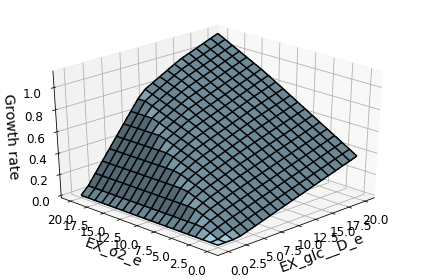

In [29]:
phase_plane_data.plot()

### 4) Simulate growth over a cross section of the above plot
 - Constrain the lower bound on oxygen uptake to 20 $\frac{mmol}{gDW \cdot hr}$
 - Simulate varying glucose uptake lower bounds ranging from 0 to 20
  - Use 40 intermediate points
 - Save the growth rate predictions from each condition as a **list**
 
**Hint:** The range of glucose values meeting the conditions outlined above can be found using the `numpy.linspace()` function. This can be used to create, for instace, an array ranging from 0 to 1 with 10 points:

In [30]:
numpy.linspace(0, 1, 10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [31]:
bounds = numpy.linspace(0, 20)
grs = []
model.reactions.EX_o2_e.lower_bound = -20
for i in bounds:
    model.reactions.EX_glc__D_e.lower_bound = -i
    grs.append(model.slim_optimize())

### 5) Visualize the solution as a line plot using the `pyplot.plot()` function
- Plot the lower bound on glucose uptake on the x-axis and the growth rate on the y-axis
- Set appropriate x- and y-axis labels similar to in Exercise 2
- Note the appearance of three distinct growth regions where increase in growth rate with increase glucose has a different slope

Text(0,0.5,'Growth Rate')

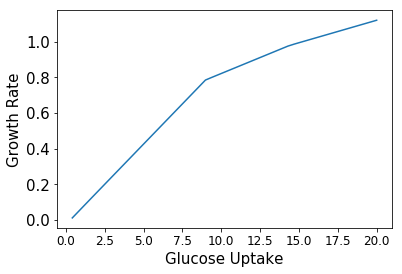

In [32]:
pyplot.plot(bounds, grs)
pyplot.xlabel('Glucose Uptake')
pyplot.ylabel('Growth Rate')

### 6) Simulate growth in each of the regions to determine the region's growth characteristics
**Hint:** Use the ideas and methods used above (change in growth byproducts, visualizing over flux maps, metabolite flux balance summaries)

In [33]:
# Region 1 purely aerobic growth
model.reactions.EX_glc__D_e.lower_bound = -5
solution = cobra.flux_analysis.pfba(model)
model.summary()

IN FLUXES            OUT FLUXES    OBJECTIVES
-------------------  ------------  ----------------------
o2_e      11.6       h2o_e  23.8   BIOMASS_Ec_i...  0.426
glc__D_e   5         co2_e  12.5
nh4_e      4.6       h_e     3.91
pi_e       0.411
so4_e      0.107
k_e        0.0831
fe2_e      0.00684
mg2_e      0.00369
ca2_e      0.00222
cl_e       0.00222
cu2_e      0.000302
mn2_e      0.000294
zn2_e      0.000145
ni2_e      0.000137


In [34]:
# Region 2 beginning of respiro-fermentation
model.reactions.EX_glc__D_e.lower_bound = -12.5
solution = cobra.flux_analysis.pfba(model)
model.summary()

IN FLUXES            OUT FLUXES       OBJECTIVES
-------------------  ---------------  ----------------------
o2_e      20         h2o_e  46        BIOMASS_Ec_i...  0.911
glc__D_e  12.5       co2_e  21.9
nh4_e      9.84      h_e    16.2
pi_e       0.879     ac_e    7.82
so4_e      0.23      for_e   0.00224
k_e        0.178
mg2_e      0.00791
fe2_e      0.00752
fe3_e      0.00712
ca2_e      0.00474
cl_e       0.00474
cu2_e      0.000646
mn2_e      0.00063
zn2_e      0.000311
ni2_e      0.000294


In [35]:
visualize_flux(solution.fluxes)

In [36]:
# Region 3 - Less use of PDH to avoid NADH production
model.reactions.EX_glc__D_e.lower_bound = -17.5
solution = cobra.flux_analysis.pfba(model)
model.summary()

IN FLUXES            OUT FLUXES    OBJECTIVES
-------------------  ------------  ---------------------
o2_e      20         h2o_e  49     BIOMASS_Ec_i...  1.06
glc__D_e  17.5       h_e    31.1
nh4_e     11.4       co2_e  21.1
pi_e       1.02      ac_e   19.1
so4_e      0.266     for_e   2.32
k_e        0.206
mg2_e      0.00918
fe2_e      0.00873
fe3_e      0.00826
ca2_e      0.00551
cl_e       0.00551
cu2_e      0.00075
mn2_e      0.000731
zn2_e      0.000361
ni2_e      0.000342


In [37]:
visualize_flux(solution.fluxes)

## C) Modeling antimicrobial mechanisms
**Goal:** 

Use metabolic models to understand how common antibiotics (ampicillin, sulfonamides) function to kill bacteria

**Mechanisms of action:**
 1. Amoxicillin is a beta-lactam antibiotic with a mechanism of action that irreversibly inhibits transpeptidases (b0084, ftsI)

 2. Sulfonamides competitively inhibit dihydropteroate synthase (b3177, folP)

### 1) Load a new model saved as a variable called `model`

In [38]:
model = cobra.io.load_json_model('../qbio_resources/iML1515.json')

### 2) Knock out the gene/reactions inhibited by amoxicillin

In [39]:
model.genes.b0084.knock_out()

### 3) Optimize model to ensure that the antibiotic indeed kills the cell

In [40]:
model.optimize()

,fluxes,reduced_costs
ALATA_D2,0.000000e+00,2.368476e-15
SHCHD2,0.000000e+00,1.380507e-30
CPPPGO,2.963060e-32,0.000000e+00
GTHOr,-2.498925e-31,9.860761e-32
DHORD5,1.389123e-31,-5.496162e-33
...,...,...
SUCCt1pp,0.000000e+00,0.000000e+00
QUINDH,0.000000e+00,3.731624e-16
LCARSyi,0.000000e+00,0.000000e+00
BIOMASS_Ec_iML1515_core_75p37M,0.000000e+00,2.614489e-16


### 4) Find the essential metabolite(s) that can no longer be synthesized in the presence of amoxicillin
 This can be accomplished by iterating through the metabolites in the biomass objective function and:
 1. Create a new "demand" reaction that consumes the metabolite with the form `metabolite_1 -> `
 2. Set this new demand reaction as the model objective
 3. Maximize flux through this objective by optimizing the model
 4. Print the metabolite or demand reaction ID if the maximum flux is zero
  - Recall the flux through the objective reaction can be found with `model.optimize().f`

In [41]:
def determine_blocked_biomass(model):
    for met in model.reactions.BIOMASS_Ec_iML1515_core_75p37M.metabolites:
        r = cobra.Reaction('DM_%s' % met.id)
        model.add_reaction(r)
        r.add_metabolites({met: -1})
        model.objective = r
        sol = model.optimize()
        if abs(sol.f) < .001:
            print('Metabolite (%s, %s) is blocked' % (met.id, met.name))

In [42]:
determine_blocked_biomass(model)

Metabolite (murein5px4p_p, Two disacharide linked murein units, pentapeptide crosslinked tetrapeptide (A2pm->D-ala) (middle of chain)) is blocked


### 5) Repeat the above steps for the gene/reactions inhibited by sulfonamides

In [43]:
model = cobra.io.load_json_model('../qbio_resources/iML1515.json')
model.genes.get_by_id('b3177').knock_out()
determine_blocked_biomass(model)

Metabolite (10fthf_c, 10-Formyltetrahydrofolate) is blocked
Metabolite (mlthf_c, 5,10-Methylenetetrahydrofolate) is blocked
Metabolite (thf_c, 5,6,7,8-Tetrahydrofolate) is blocked


**Amoxicillin disrupts cell wall synthesis**
 - Murein is an essential part of cell wall formation
 
**Sulfonamides disrupt folate metabolism**
 - Tetrahydrofolates (vitamin B9) are essential for donating one carbon units (hydroxymethyl/formyl groups) during metabolite biosynthesis